# Airbender

In [1]:
# conda install pandas
# conda install matplotlib
# conda install -c derickl coremltools
import pandas as pd
import numpy as np
import glob

In [105]:
acc_names = ["acc" + str(x) for x in range(1, 101)]
acc_names.insert(0, "Gesture")
acc_names.insert(0, "Participant")
data_names = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]

all_files = glob.glob("./data_resampled/*.csv")

class_names = ["Gesture", "Participant"]
classes = range(0,12)

data = []

for file in all_files:
    df = pd.read_csv(file, sep=";", names=acc_names).dropna()
    data.append(df)

#frame = pd.concat((frame[frame.columns.difference(class_names)] for frame in list[0:6]), axis = 1, ignore_index = True)

In [3]:
data[0].shape

(221, 102)

In [4]:
data[0].head()

,Participant,Gesture,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,...,acc91,acc92,acc93,acc94,acc95,acc96,acc97,acc98,acc99,acc100
0,Gix1,0,0.006969,0.000848,-0.000720,-0.009030,-0.004277,0.000759,0.002966,-0.000850,...,0.001368,-0.000564,-0.001737,-0.001106,-0.006170,-0.005773,-0.002984,0.000482,0.002133,0.002793
1,Gix1,1,-0.009553,-0.011066,-0.004418,-0.003037,-0.002963,-0.007740,-0.004091,-0.004082,...,-0.002965,-0.005508,-0.006514,-0.011621,-0.011665,-0.010188,-0.003994,0.007893,0.011737,0.008740
2,Gix1,2,-0.005957,-0.010512,-0.020735,-0.043233,-0.049574,-0.041784,0.066144,0.179850,...,0.023357,0.025490,0.021612,0.010510,0.003288,0.009596,0.001628,0.008208,0.002435,-0.012939
3,Gix1,3,-0.006112,0.001685,-0.009567,-0.002749,-0.003493,0.003675,0.016477,-0.004954,...,0.053803,0.054990,0.045988,0.042890,0.037902,0.049565,0.051274,0.053112,0.066124,0.039360
4,Gix1,4,-0.002025,-0.008841,-0.012501,-0.006683,-0.005849,-0.003792,-0.009695,0.004547,...,0.030336,0.034947,0.042776,0.055322,0.058870,0.040724,0.013058,-0.011792,-0.025957,-0.041154


In [5]:
import matplotlib.pyplot as plt

### Plot some info about data

In [6]:
data_x = data[0].values[:, ~data[0].columns.isin(class_names)]
plot_data = data_x[0].astype(np.float32, copy=False)

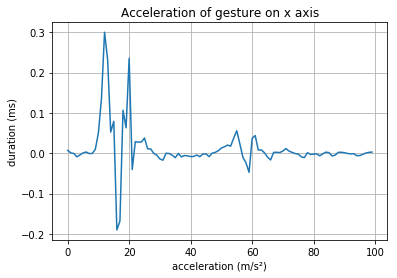

In [7]:
plt.plot(plot_data)
plt.title('Acceleration of gesture on x axis')

plt.xlabel('acceleration (m/s²)')
plt.ylabel('duration (ms)')

plt.grid(True)

## Features

In [155]:
features = pd.DataFrame()

### Time Domain

In [9]:
def get_time_feature(data, func):
    temp_feature = pd.DataFrame()
    count=0
    for frame in data:
        mean_df = pd.DataFrame(frame.iloc[:,2:102].apply(func, axis=1), columns=[data_names[count] + "_" + func.__name__])
        temp_feature = pd.concat([temp_feature, mean_df], axis=1, sort=False)
        count+=1
        
    return temp_feature

### FFT

In [10]:
def get_magnitude_band(data, band_width):
    temp_feature = pd.DataFrame()
    def get_band(row, band_width, label):
        fft = np.fft.fft(row)
        magnitude = np.abs(fft)
        return pd.Series(magnitude[1:band_width+1],index=[label + "_" + str(x) for x in range(1,band_width+1)])

    count=0
    for frame in data:
        bands = frame.iloc[:,2:102].apply(lambda x:get_band(x, 40, data_names[count]), axis=1)
        temp_feature = pd.concat([temp_feature, bands], axis=1, sort=False)
        count+=1
    
    return temp_feature

### Combine features

In [156]:
time_mean_feature = get_time_feature(data, np.mean)
time_median_feature = get_time_feature(data, np.median)
band_feature = get_magnitude_band(data, 40)

features = pd.concat([data[0].iloc[:, 0:2], band_feature, time_mean_feature, time_median_feature], axis=1, sort=False)
features.head()

,Participant,Gesture,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,...,acc_z_mean,gyr_x_mean,gyr_y_mean,gyr_z_mean,acc_x_median,acc_y_median,acc_z_median,gyr_x_median,gyr_y_median,gyr_z_median
0,Gix1,0,0.794090,1.005742,0.721146,0.347478,0.518088,0.368990,0.747492,0.817477,...,0.046764,0.010857,-0.038941,0.037328,0.000313,0.004846,-0.000425,-0.016573,-0.010473,0.003911
1,Gix1,1,0.355114,0.244761,0.150839,0.320401,0.300359,0.656048,0.956027,1.075988,...,0.087920,-0.138966,-0.128692,-0.047215,-0.002237,0.005129,0.001105,-0.037563,-0.014070,0.003953
2,Gix1,2,5.020193,1.003083,5.826102,5.456611,2.458544,2.207982,3.477358,2.259109,...,-0.064488,-0.121927,0.399692,-0.081435,0.013522,0.006505,-0.009090,-0.052258,0.019490,0.063182
3,Gix1,3,7.015175,9.788621,11.884952,9.058822,4.679105,4.317239,3.659451,2.485352,...,0.049187,-0.180858,0.219811,0.292866,0.004348,0.028478,0.011076,-0.050098,-0.003921,0.084514
4,Gix1,4,9.536236,11.633247,11.913941,6.681486,4.584427,6.230385,4.161665,3.006227,...,0.050565,-0.421599,0.504356,0.147644,-0.002837,0.003560,0.013289,-0.079472,0.027011,0.085861


In [77]:
plot_data = features.iloc[0,0:40]
n = plot_data.size
timestep = 0.02
freq = np.arange(0.5, 20.5, 0.5)
freq

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

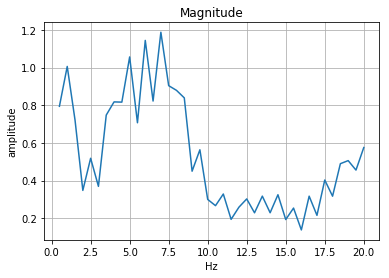

In [13]:
plt.plot(freq, plot_data)
plt.title('Magnitude')

plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.grid(True)

## Feature Reduction

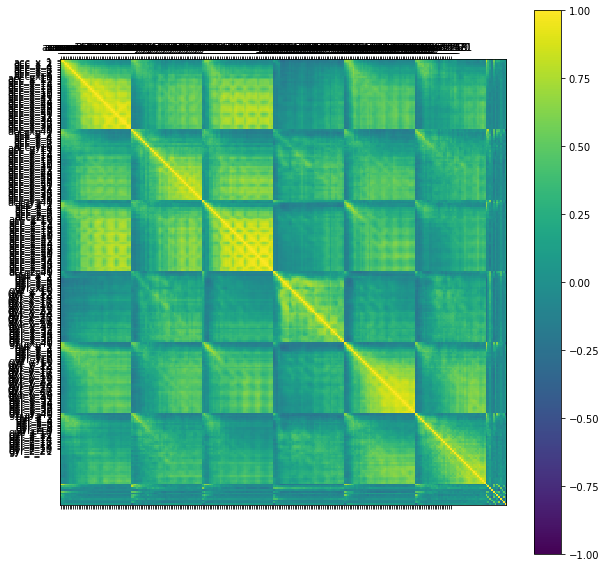

In [164]:
correlations = features.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features.iloc[:, 2:]),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.iloc[:, 2:].columns)
ax.set_yticklabels(features.iloc[:, 2:].columns)
plt.show()

In [165]:
### drop features
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
original_length = len(features.iloc[0])
features = features.drop(to_drop, axis=1)
print("Dropped {:.0f} features".format(original_length - len(features.iloc[0])))

Dropped 85 features


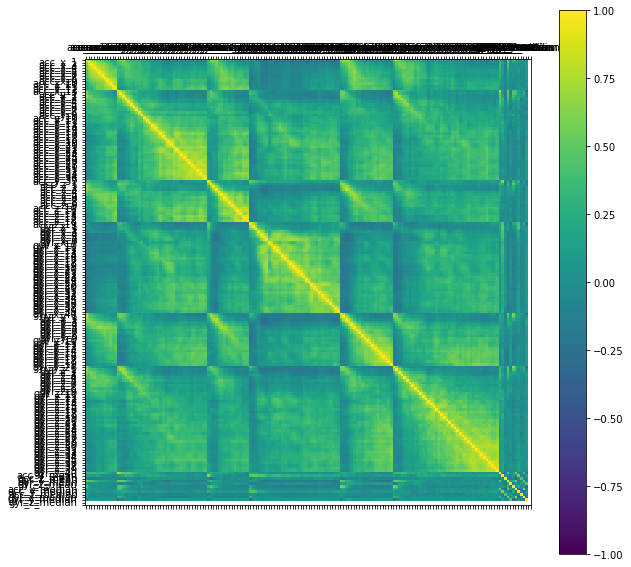

In [169]:
correlations = features.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features.iloc[0]),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.iloc[:, 2:].columns)
ax.set_yticklabels(features.iloc[:, 2:].columns)
plt.show()

## Data Partitioning

In [161]:
X = features.iloc[:,2:].values
y = data[0].iloc[:, 1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

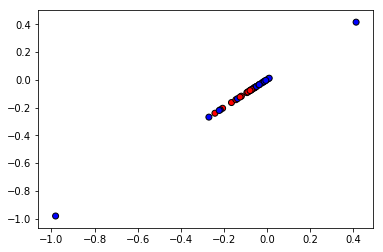

In [269]:
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap

def plot_scatter(features, gestures, feature):
    ax = plt.subplot(1, 1, 1)
    data = features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), feature] 
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    classes_scatter=features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), "Gesture"]
    ax.scatter(data, data, c=classes_scatter, cmap=cm_bright, edgecolors='k')
    
plot_scatter(features, [0,9], 'gyr_x_median')

## Models

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
    
def get_rf(X_train, y_train):
    # Number of trees in random forest
    n_estimators = np.power(range(1,18),3)
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = np.power(range(1,8),3)
    # Minimum number of samples required to split a node
    #min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    #min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    #bootstrap = [True, False]
    # Create the random grid
    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        #'min_samples_split': min_samples_split,
        #'min_samples_leaf': min_samples_leaf,
        #'bootstrap': bootstrap
    }

    #clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    clf_rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf_rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer

def get_knn(X_train, y_train):
    # Number of trees in random forest
    n_neighbors = range(1,100)
    param_grid = {
        'n_neighbors': n_neighbors
    }
    
    clf = KNeighborsClassifier(n_neighbors=3)
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid = GridSearchCV(clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [83]:
# RF
rf = get_rf(X_train, y_train)
print("[INFO] grid search best score: {}".format(rf.best_score_))
print("[INFO] grid search best parameters: {}".format(rf.best_params_))
acc = rf.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 3 folds for each of 238 candidates, totalling 714 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 714 out of 714 | elapsed:  5.0min finished
C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[INFO] grid search best score: 0.32323232323232326
[INFO] grid search best parameters: {'max_depth': 27, 'max_features': 'auto', 'n_estimators': 512}
[INFO] grid search test accuracy: 30.43%


In [82]:
# KNN
knn = get_knn(X_train, y_train)
print("[INFO] grid search best score: {}".format(knn.best_score_))
print("[INFO] grid search best parameters: {}".format(knn.best_params_))
acc = knn.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] grid search best score: 0.26993564993564995
[INFO] grid search best parameters: {'n_neighbors': 3}
[INFO] grid search test accuracy: 17.39%


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.4s finished


## Test model

In [68]:
from sklearn.metrics import confusion_matrix

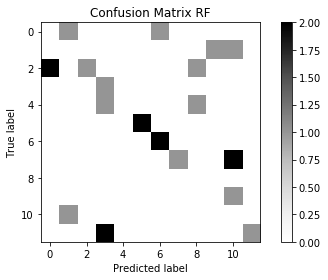

In [69]:
### Random Forest
rf_predicted_y = rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_predicted_y)

plt.imshow(rf_cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Confusion Matrix RF")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

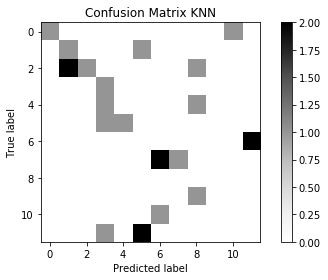

In [71]:
### KNN
knn_predicted_y = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predicted_y)

plt.imshow(knn_cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Confusion Matrix KNN")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Evaluate Model

In [72]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, precision_score

In [73]:
### Random Forest
print(classification_report(y_test, rf_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, rf_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, rf_predicted_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       1.00      0.25      0.40         4
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      0.33      0.50         3

   micro avg       0.35      0.35      0.35        23
   macro avg       0.41      0.33      0.30        23
weighted avg       0.59      0.35      0.37        23

Accuracy: 0.348
MSE: 20.478


C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [74]:
### KNN
print(classification_report(y_test, knn_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, knn_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, knn_predicted_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.33      0.50      0.40         2
           2       1.00      0.25      0.40         4
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3

   micro avg       0.22      0.22      0.22        23
   macro avg       0.30      0.22      0.20        23
weighted avg       0.43      0.22      0.24        23

Accuracy: 0.217
MSE: 16.565


C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Save Model

In [23]:
import pickle
filename = 'randomForest.model'
pickle.dump(clf_rf, open(filename, 'wb'))